<h1>Estimation of erosion using precipitation data</h1>
<p style="font-size: 20px; line-height:2.2rem;">Precipitation data was provided from satellite images for each 20mins for 3 years, we need to clean the data so that we could use it as parameters in the models</p>

In [2]:
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

<p style="font-size:20px; line-height:2.2rem;">The rain data is provided in 9 files as they were processed by 9 servers, to load them we are going to load each file individually and then append the data to one main data frame we call it df_rain, and for erosion we are going to load a pre processed data file and create a data frame for it called df_erosion</p>

In [3]:
def load_rain_data(dir_path):
    """
    load the erosion and rain data
    :return: df_rain, df_erosion
    """

    df_rain = pd.DataFrame()
    _, _, files = next(os.walk(dir_path))
    for file in files:
        file_path = dir_path + file
        df_rain = df_rain.append(pd.read_excel(file_path))
    
    # set the index as time and sort it
    df_rain['time'] = df_rain['time'].astype('object')
    df_rain.set_index('time', inplace=True)
    df_rain.sort_index(inplace=True)
    
    # load the df_erosion
    df_erosion = pd.read_excel('erosion_data.xlsx')
    return df_rain, df_erosion

In [4]:
dir_path = 'rain_data/'
df_rain, df_erosion = load_rain_data(dir_path)

In [5]:
df_rain.head()

,Unnamed: 0,area1_average,area1_min,area1_max,area2_average,area2_min,area2_max,area3_average,area3_min,area3_max,...,area6_max,area7_average,area7_min,area7_max,area8_average,area8_min,area8_max,area9_average,area9_min,area9_max
time,,,,,,,,,,,,,,,,,,,,,
200809020000,4044,--,--,--,--,--,--,--,--,--,...,--,--,--,--,--,--,--,--,--,--
200809020015,2408,--,--,--,--,--,--,--,--,--,...,--,--,--,--,--,--,--,--,--,--
200809020030,4399,--,--,--,--,--,--,--,--,--,...,--,--,--,--,--,--,--,--,--,--
200809020045,4915,--,--,--,--,--,--,--,--,--,...,--,--,--,--,--,--,--,0.000115,--,--
200809020100,34,--,--,--,--,--,--,--,--,--,...,--,--,--,--,--,--,--,0.00008,--,--


In [6]:
df_erosion

,id,erosion_protocol,area_ha_2010,area_ha_2009,area_ha_2008,plowing_2010,plowing_2009,plowing_2008,other_basic_cultivation_2010,other_basic_cultivation_2009,...,sedimentation_erosion_2010,sedimentation_erosion_2009,sedimentation_erosion_2008,other_erosion_2010,other_erosion_2009,other_erosion_2008,participation in AKG program 2010,participation in AKG program 2009,participation in AKG program 2008,area
0,05017/08,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,area1
1,05006/04,1,9.0,9.3,9.3,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,11 - ökológiai gyepgazdálkodási célprogram,11 - ökológiai gyepgazdálkodási célprogram,14 - ökológiai gyepgazdálkodási célprogram,area1
2,05004/08,1,8.4,9.7,9.7,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0 - nem vett részt AKG programban,0 - nem vett részt AKG programban,0 - nem vett részt AKG programban,area1
3,05011/01,1,63.6,63.6,63.6,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1 - integrált szántóföldi növénytermesztési cé...,1 - integrált szántóföldi növénytermesztési cé...,1 - alapszintû szántóföldi célprogram,area1
4,05019/04,1,14.3,14.3,14.3,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,16 - integrált gyümölcs- és szõlõtermesztés cé...,16 - integrált gyümölcs- és szõlõtermesztés cé...,19 - integrált ültetvény célprogram,area1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,17002/07,1,55.0,55.0,55.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0 - nem vett részt AKG programban,0 - nem vett részt AKG programban,0 - nem vett részt AKG programban,area9
61,02001/07,1,23.2,23.2,23.2,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3 - ökológiai szántóföldi növénytermesztési cé...,3 - ökológiai szántóföldi növénytermesztési cé...,5 - ökológiai szántóföldi növénytermesztési cé...,area9
62,02009/05,1,19.7,19.7,19.7,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0 - nem vett részt AKG programban,0 - nem vett részt AKG programban,1 - alapszintû szántóföldi célprogram,area9
63,02017/30,1,152.0,152.0,152.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0 - nem vett részt AKG programban,0 - nem vett részt AKG programban,0 - nem vett részt AKG programban,area9


In [7]:
def get_data_time(time_list, target):
    """
    get timeslist for the same target time example: target of 20080302: would list all the times in 
    time_list that have a timestamp of 20080302 at the beginning

    :param time_list:         time list to get the target list from 
    :param target:            target time stamp
    :return:                  sorted list of times that belong to the same target timestamp
    """
    
    assert(type(target) == int)
    target_index = len(str(target))
    
    sum_list = []
    for time in time_list: # time: YYYYMMDDHHHH
        if int(str(time)[: target_index]) == target:
            sum_list.append(time)
    return sorted(sum_list)

def append_aggregated_dataframe(df, agg_df, period, aggregate_func, columns, axis=0, zerona=True):
    """
    aggregates the time vs precipitation according to the period and aggregate function

    :param param df:       data frame to apply aggregation to 
    :param agg_df:         data frame to append the data to
    :param aggregate_fun:  aggregation function to apply
    :param period:         int of a month or a year to apply the aggregation along
    :param target_columns: columns from main df to select
    :param axis:           axis at which the aggregation function is applied
    :param zerona:         replace na with 0
    :return:               aggregated dataframe with the new row appended
    """
    
    times = get_data_time(df.index.values, period)
    if not times:
        # in this case we don't want to modify the aggregated data frame
        return agg_df
    
    # locate the target times
    _df = df.loc[times[0]: times[-1]]
    
    if zerona:
        _df = _df.fillna(0)
    
    # apply the aggregation function
    _df = _df.reset_index()[columns].apply(aggregate_func, axis=axis)
    _df['time'] = str(period)

    return agg_df.append(_df, ignore_index=True)

In [8]:
# pre process the rain data, removing all masked data points and 
# converting all fieldds to numeric fields# draw heatmap
# mask = np.zeros_like(_df.corr())
# mask[np.triu_indices_from(mask)] = True
# with sns.axes_style("white"):
#     f, ax = plt.subplots(figsize=(21, 15))
#     ax = sns.heatmap(_df.corr(), mask=mask, vmax=.3, square=True, annot=True)
#     ax.set_title('Correlation Heat Map Without Rain Data', fontsize=21)
     
#     # increase the fontsize
#     for label in (ax.get_xticklabels() + ax.get_yticklabels()):
#         label.set_fontsize(16)
df1 = df_rain.apply(pd.to_numeric, args=('coerce',))

In [9]:
# note that all masked values were converted to NaN values (not a number) which is going to be handy
# when analysing the data
df1

,Unnamed: 0,area1_average,area1_min,area1_max,area2_average,area2_min,area2_max,area3_average,area3_min,area3_max,...,area6_max,area7_average,area7_min,area7_max,area8_average,area8_min,area8_max,area9_average,area9_min,area9_max
time,,,,,,,,,,,,,,,,,,,,,
200809020000,4044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200809020015,2408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200809020030,4399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200809020045,4915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000115,NaN,NaN
200809020100,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000080,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201011301515,5350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201011301530,3134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201011301545,3543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
def aggregate_rain_data(df, periods, agg_func, columns):
    """
    function to aggregated the rain data according to an aggregation function
    :parma df:       rain dataframe
    :parma periods:  periods at which the aggregation should happend "YYYYMMDDHHHH"
    :parma agg_func: aggregation function
    :parma columns:  rain dataframe
    :return:         aggregated rain dataframe
    """
    aggregated_df = pd.DataFrame()
    
    for period in periods:
        aggregated_df = append_aggregated_dataframe(df, aggregated_df, period, agg_func, columns)
    return aggregated_df

In [11]:
def average(x):
    """
    calculated the averaged including nan values
    :param x: value or numpy array/ series
    :return:  average
    """
    x.replace(0, np.nan)
    masked_data = np.ma.masked_array(x, np.isnan(x))
    # calculate your weighted average here instead
    avg = np.ma.average(masked_data)
    return avg



def get_yearly_aggregated_rain_erosion_df(df_rain, df_erosion, year, agg_func, cols):
    """
    function to get the rain/erosion data frame for one year according, rain
    information would be aggregated according to an aggregation function agg_func
    :param df_rain:    rain dataframe
    :param df_erosion: erosion dataframe
    :param year:       target year
    :agg_func:         aggregation function for rain dataframe
    :param cols:       columns to take from the rain dataframe
    """
    periods = []
    for month in range(1, 13):
        for day in range(1, 32):
            y = str(year)
            m = '0' + str(month) if len(str(month)) == 1 else str(month)
            d = '0' + str(day) if len(str(day)) == 1 else str(day)
            period = y+m+d
            periods.append(int(period))
                    
    aggregated_df = aggregate_rain_data(df_rain, periods, agg_func, cols)
    # get the rain data monthly using comulative method
    df_sub = aggregated_df.set_index('time')
    df_sub.columns = ['area{}'.format(i) for i in range(1, 10)]
    df_sub
    df_t = df_sub.transpose()
    
    df_erosion_year = df_erosion[[i for i in df_erosion.columns if i.endswith(f'_{year}')] + ['area']]
    df_er = df_erosion_year.set_index('area')
    df_rain_erosion = df_er.merge(df_t, left_index=True, right_index=True)
    df_rain_erosion.to_excel('df_rain_erosion_daily.xlsx')
    return df_rain_erosion

In [12]:
def data_wrangle():
    """
    function to wrangle the rain and erosion data and produces 
    :return: wrangled dataframe with the erosion/rain information
    """
    COLS = [f'area{x}_average' for x in range(1, 10)]
    YEARS = [2008, 2009, 2010]
    df_years = pd.DataFrame()
    for year in YEARS:
        df_year = get_yearly_aggregated_rain_erosion_df(df1, df_erosion, year, average, COLS)
        rain_data_columns = [col for col in df_year.columns if col.isnumeric()]
        # we need to remove the year from the heading so we can merge all the dfs together
        print(df_year.columns)
        df_year.columns = ['_'.join(col.split('_')[:-1]) for col in df_year.columns if '_' in col] + rain_data_columns
        # append the dfs together
        df_years = df_year.append(df_year)
    return df_years

In [13]:
# # model
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# log_r = LogisticRegression()
# X = df_rain_erosion.dropna()[[i for i in df_rain_erosion if i.isnumeric()]]
# y = df_rain_erosion.dropna()['rill_erosion_2009']
# X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.33)
# log_r.fit(X_train, y_train)
# pred = log_r.predict(X_test)
# print(accuracy_score(pred, y_test))
# pred

In [14]:
df_years = data_wrangle()

Index(['area_ha_2008', 'plowing_2008', 'other_basic_cultivation_2008',
       'continuous_cultivation_2008', 'crop_rotation_2008', 'mulching_2008',
       'strip_cultivation_2008', 'reduced_cultivation_2008',
       'direct_sowing_2008', 'grassing_2008',
       ...
       '20081222', '20081223', '20081224', '20081225', '20081226', '20081227',
       '20081228', '20081229', '20081230', '20081231'],
      dtype='object', length=139)
Index(['area_ha_2009', 'plowing_2009', 'continuous_cultivation_2009',
       'crop_rotation_2009', 'mulching_2009', 'strip_cultivation_2009',
       'reduced_cultivation_2009', 'direct_sowing_2009', 'grassing_2009',
       'terracing_2009',
       ...
       '20091222', '20091223', '20091224', '20091225', '20091226', '20091227',
       '20091228', '20091229', '20091230', '20091231'],
      dtype='object', length=285)
Index(['area_ha_2010', 'plowing_2010', 'other_basic_cultivation_2010',
       'continuous_cultivation_2010', 'crop_rotation_2010', 'mulching_201

In [15]:
df_years
df_years.to_excel('output.xlsx')

In [16]:
_df = df_years[[col for col in df_years.columns if not col.isnumeric()]].dropna()

In [17]:
# corr between all non rain_data and erosion
_df.corr()

,area_ha,plowing,other_basic_cultivation,continuous_cultivation,crop_rotation,mulching,strip_cultivation,reduced_cultivation,direct_sowing,grassing,terracing,affected_by_water_management,raindrop_erosion,rill_erosion,gully_erosion,sedimentation_erosion,other_erosion
area_ha,1.000000,-0.069607,0.067599,0.107035,-0.010116,0.023252,-0.069727,-0.071121,0.602724,-0.151959,-0.119878,-0.051401,0.071516,0.189894,-0.084550,-0.043355,-0.063895
plowing,-0.069607,1.000000,-0.189490,0.195781,0.196702,-0.312010,-0.171102,-0.397736,-0.171102,-0.351250,-0.244051,-0.051379,0.538028,0.359425,0.099059,0.104280,0.141293
other_basic_cultivation,0.067599,-0.189490,1.000000,-0.126075,-0.170346,0.124484,-0.121781,0.283965,0.139178,0.017857,0.012407,0.012407,0.047246,0.077152,0.139178,0.322329,0.012407
continuous_cultivation,0.107035,0.195781,-0.126075,1.000000,0.123351,0.226144,0.177418,-0.017471,-0.095533,-0.196116,0.253060,0.253060,0.148250,0.060523,0.177418,0.031607,0.253060
crop_rotation,-0.010116,0.196702,-0.170346,0.123351,1.000000,-0.009615,-0.051064,-0.196116,-0.051064,-0.104828,-0.072836,-0.072836,0.034669,0.113228,-0.051064,-0.118262,0.200298
mulching,0.023252,-0.312010,0.124484,0.226144,-0.009615,1.000000,-0.051064,0.171602,-0.051064,0.288278,0.473432,0.200298,-0.173344,-0.226455,-0.051064,0.059131,-0.072836
strip_cultivation,-0.069727,-0.171102,-0.121781,0.177418,-0.051064,-0.051064,1.000000,-0.065094,-0.016949,-0.034794,-0.024175,-0.024175,-0.092057,-0.075165,-0.016949,-0.039253,-0.024175
reduced_cultivation,-0.071121,-0.397736,0.283965,-0.017471,-0.196116,0.171602,-0.065094,1.000000,-0.065094,0.200446,0.139272,0.139272,-0.088388,-0.192450,-0.065094,0.150756,-0.092848
direct_sowing,0.602724,-0.171102,0.139178,-0.095533,-0.051064,-0.051064,-0.016949,-0.065094,1.000000,-0.034794,-0.024175,-0.024175,-0.092057,0.225494,-0.016949,-0.039253,-0.024175
grassing,-0.151959,-0.351250,0.017857,-0.196116,-0.104828,0.288278,-0.034794,0.200446,-0.034794,1.000000,-0.049629,-0.049629,-0.188982,-0.154303,-0.034794,0.161165,-0.049629


<h2>Exploriory Data Analysis</h2>

In [18]:
def set_size(w,h, ax=None):
    """
    function to set size for an ax object in inches
    :param w: width
    :param h: height
    """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

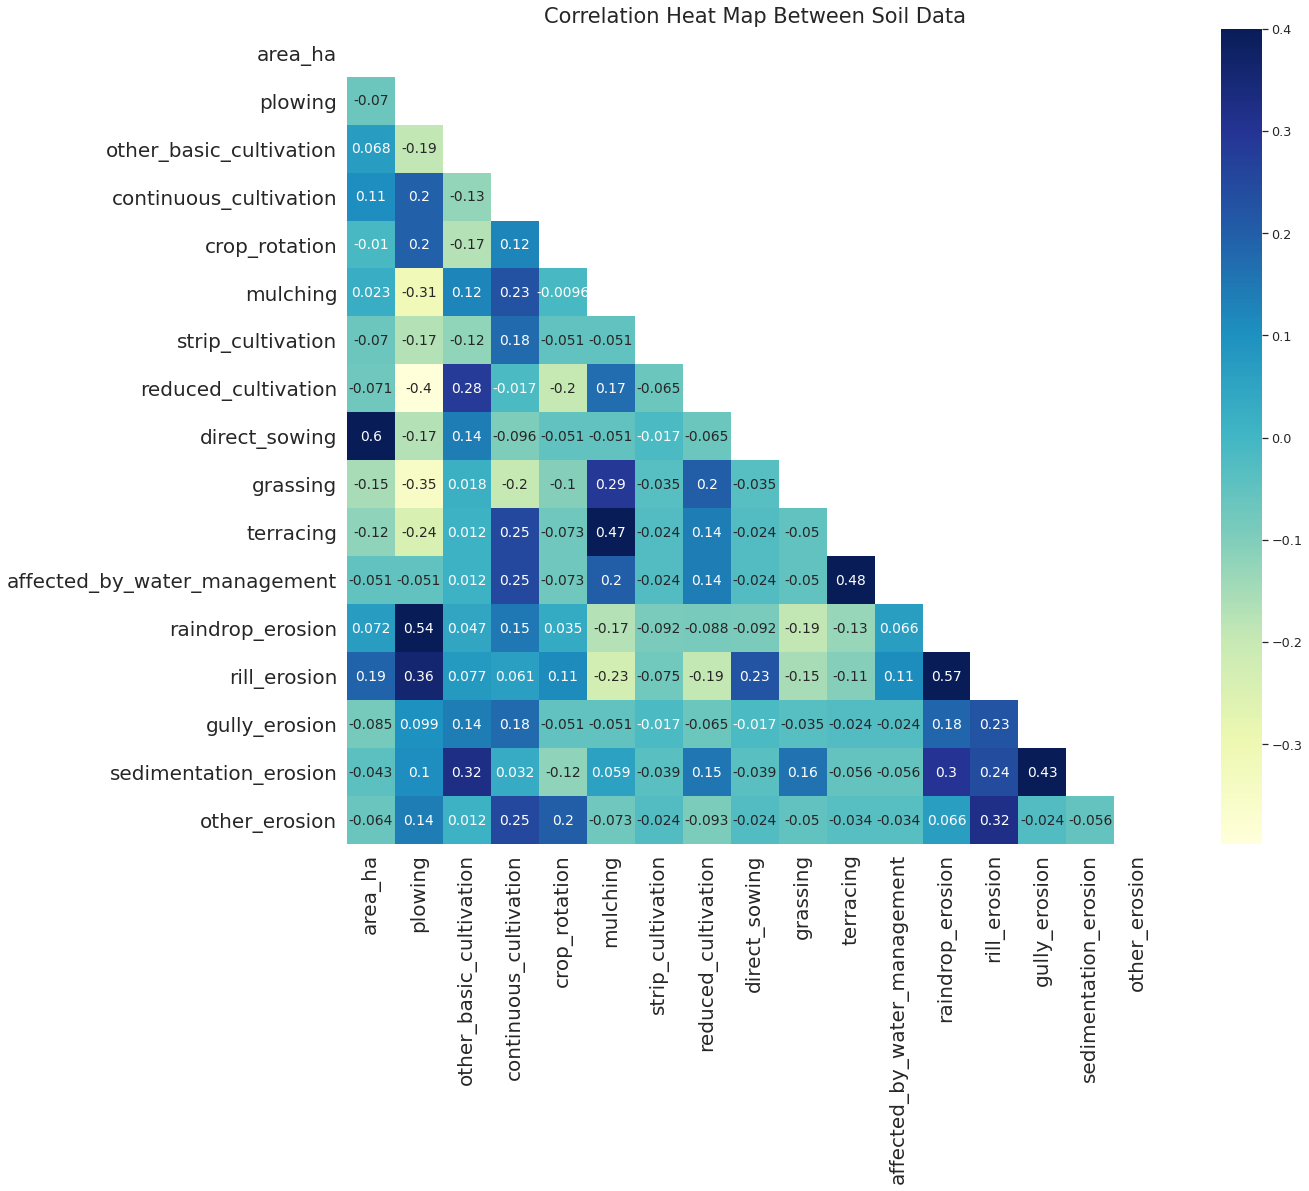

In [19]:
# draw heatmap
mask = np.zeros_like(_df.corr())
mask[np.triu_indices_from(mask)] = True

sns.set(font_scale=1.16) 
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(21, 15))
    ax = sns.heatmap(_df.corr(), mask=mask, vmax=.4, square=True, annot=True, cmap="YlGnBu")
    ax.set_title('Correlation Heat Map Between Soil Data', fontsize=21)

    # increase the fontsize
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(20)

In [20]:
df_rain = df_years.dropna()[[col for col in df_years.columns if col.isnumeric()]]
df_rain.head()

,20100101,20100102,20100103,20100104,20100105,20100106,20100107,20100108,20100109,20100110,...,20101121,20101122,20101123,20101124,20101125,20101126,20101127,20101128,20101129,20101130
area1,0.000035,0.000115,0.000152,0.0,0.0,0.0,0.0,0.000011,0.000082,0.000092,...,0.0,0.000075,0.000067,0.000016,0.0,0.0,0.000004,0.00002,0.000134,0.000113
area1,0.000035,0.000115,0.000152,0.0,0.0,0.0,0.0,0.000011,0.000082,0.000092,...,0.0,0.000075,0.000067,0.000016,0.0,0.0,0.000004,0.00002,0.000134,0.000113
area1,0.000035,0.000115,0.000152,0.0,0.0,0.0,0.0,0.000011,0.000082,0.000092,...,0.0,0.000075,0.000067,0.000016,0.0,0.0,0.000004,0.00002,0.000134,0.000113
area1,0.000035,0.000115,0.000152,0.0,0.0,0.0,0.0,0.000011,0.000082,0.000092,...,0.0,0.000075,0.000067,0.000016,0.0,0.0,0.000004,0.00002,0.000134,0.000113
area1,0.000035,0.000115,0.000152,0.0,0.0,0.0,0.0,0.000011,0.000082,0.000092,...,0.0,0.000075,0.000067,0.000016,0.0,0.0,0.000004,0.00002,0.000134,0.000113


In [21]:
cols = [f'area{x}_average' for x in range(1, 10)]
rain_year_dfs = {} # year: dataframe
for year in range(2008, 2010 + 1):
    periods = []
    for month in range(1, 12 + 1):
        y = str(year)
        m = '0' + str(month) if len(str(month)) == 1 else str(month)
        period = y+m
        periods.append(int(period))
    
    rain_year_dfs[year] = aggregate_rain_data(df1, periods, np.sum, cols)

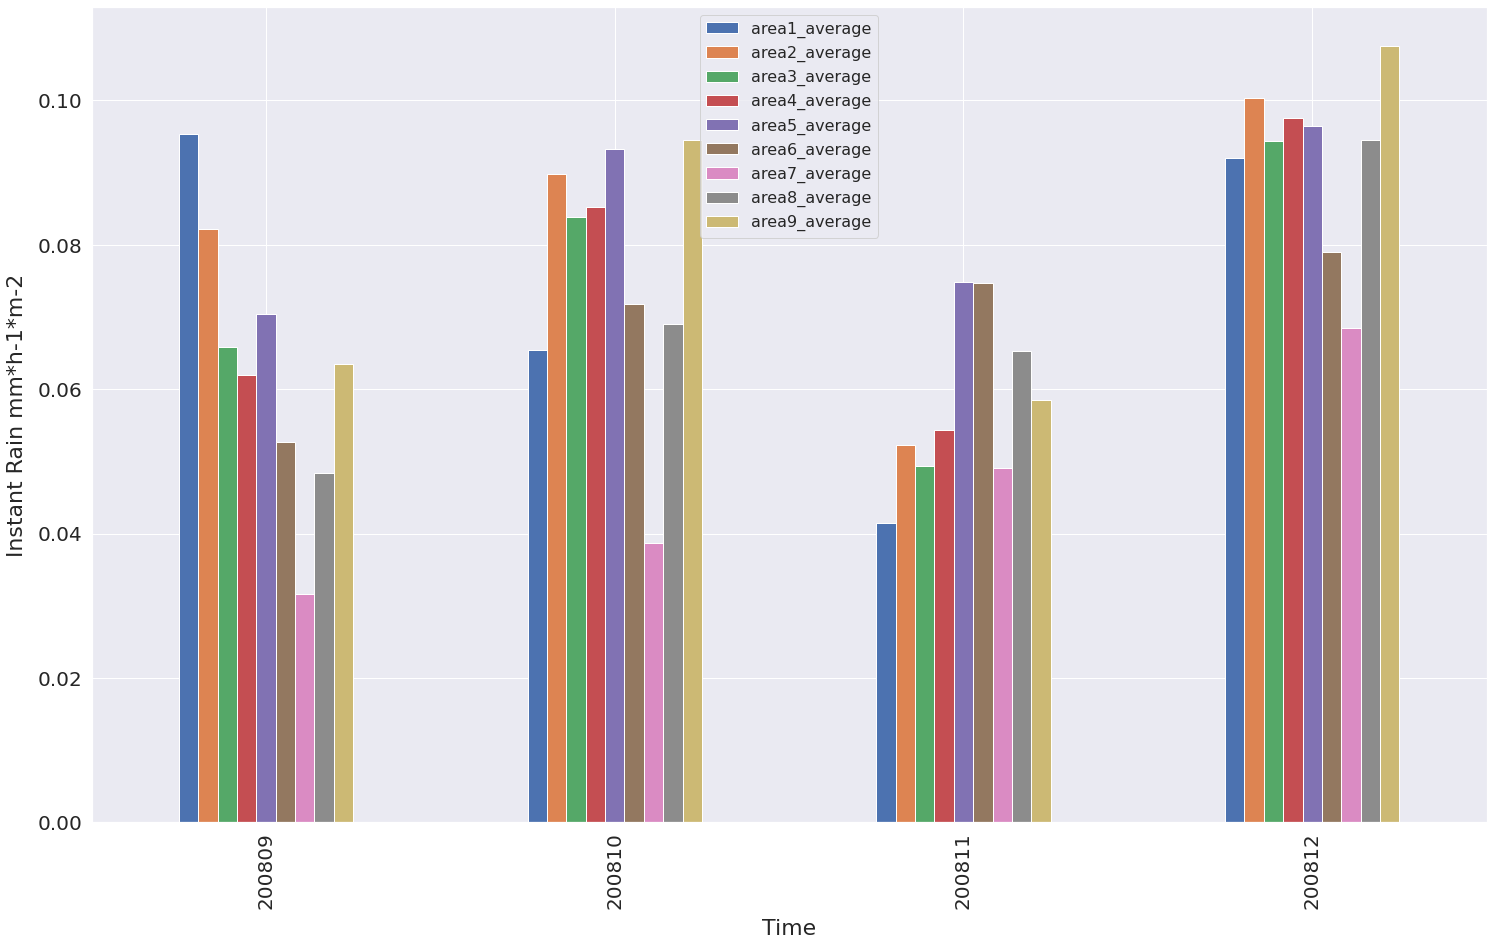

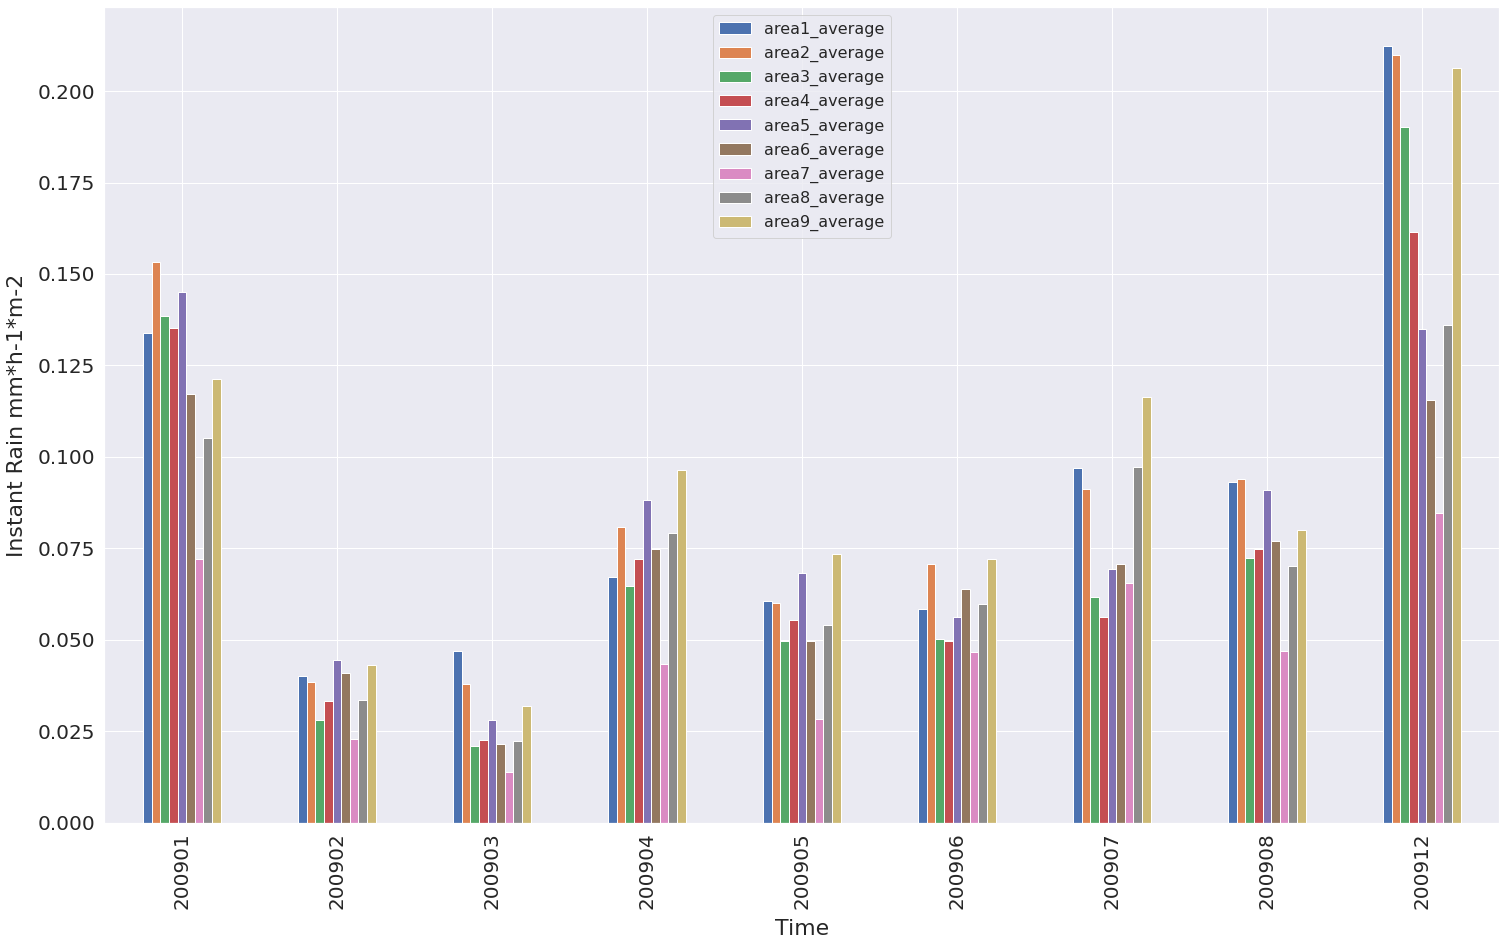

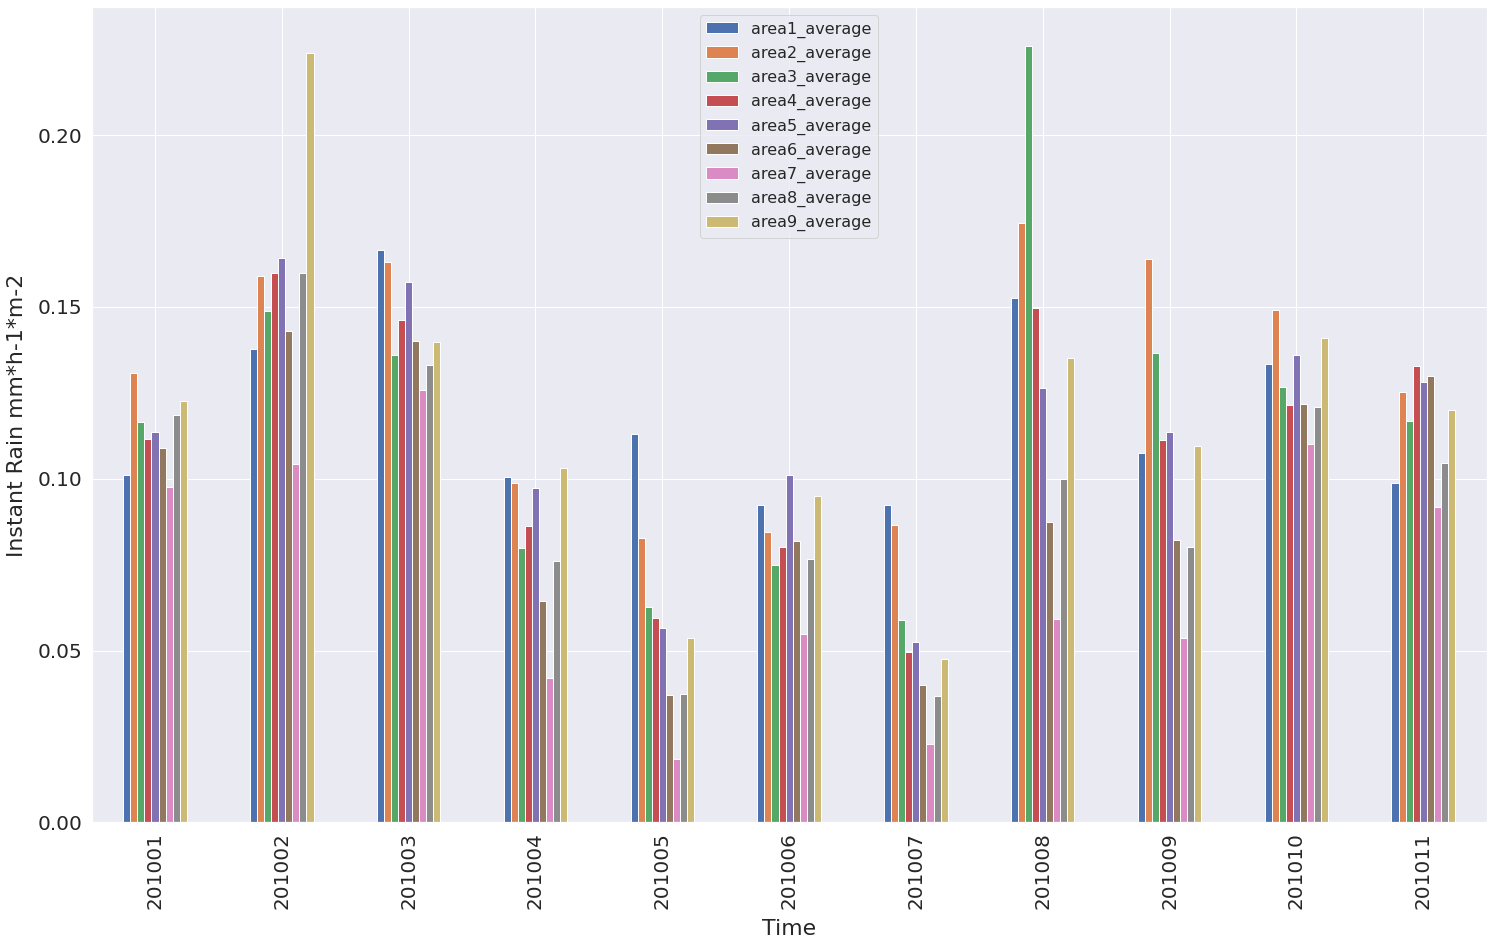

In [24]:
for year in [2008, 2009, 2010]:
    
    df = rain_year_dfs[year]
    ax = df[[col for col in df.columns]].set_index('time').plot(kind='bar', figsize=(25, 15), fontsize=20)
    ax.legend(prop={"size":16}, loc="upper center")
    ax.set_xlabel('Time', fontsize=22, labelpad=10)
    ax.set_ylabel('Instant Rain mm*h-1*m-2', fontsize=22, labelpad=10)

In [22]:
df_erosion

,id,erosion_protocol,area_ha_2010,area_ha_2009,area_ha_2008,plowing_2010,plowing_2009,plowing_2008,other_basic_cultivation_2010,other_basic_cultivation_2009,...,sedimentation_erosion_2010,sedimentation_erosion_2009,sedimentation_erosion_2008,other_erosion_2010,other_erosion_2009,other_erosion_2008,participation in AKG program 2010,participation in AKG program 2009,participation in AKG program 2008,area
0,05017/08,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,area1
1,05006/04,1,9.0,9.3,9.3,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,11 - ökológiai gyepgazdálkodási célprogram,11 - ökológiai gyepgazdálkodási célprogram,14 - ökológiai gyepgazdálkodási célprogram,area1
2,05004/08,1,8.4,9.7,9.7,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0 - nem vett részt AKG programban,0 - nem vett részt AKG programban,0 - nem vett részt AKG programban,area1
3,05011/01,1,63.6,63.6,63.6,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1 - integrált szántóföldi növénytermesztési cé...,1 - integrált szántóföldi növénytermesztési cé...,1 - alapszintû szántóföldi célprogram,area1
4,05019/04,1,14.3,14.3,14.3,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,16 - integrált gyümölcs- és szõlõtermesztés cé...,16 - integrált gyümölcs- és szõlõtermesztés cé...,19 - integrált ültetvény célprogram,area1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,17002/07,1,55.0,55.0,55.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0 - nem vett részt AKG programban,0 - nem vett részt AKG programban,0 - nem vett részt AKG programban,area9
61,02001/07,1,23.2,23.2,23.2,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3 - ökológiai szántóföldi növénytermesztési cé...,3 - ökológiai szántóföldi növénytermesztési cé...,5 - ökológiai szántóföldi növénytermesztési cé...,area9
62,02009/05,1,19.7,19.7,19.7,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0 - nem vett részt AKG programban,0 - nem vett részt AKG programban,1 - alapszintû szántóföldi célprogram,area9
63,02017/30,1,152.0,152.0,152.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0 - nem vett részt AKG programban,0 - nem vett részt AKG programban,0 - nem vett részt AKG programban,area9


In [63]:
_df.corr().to_excel('correlation.xlsx')